# 0) Modules & Functions

In [9]:
import os
import pandas as pd
from pathlib import Path
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import joblib
import subprocess
import time

RANDOM_STATES = [42, 1337, 29121997]

# === DESCRIPTOR FUNCTIONS ===
def smiles_to_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))
    return np.zeros(nBits)

def smiles_to_avalon(smiles, nBits=512):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(DataStructs.BitVectToNumPyArray(MACCSkeys.GenMACCSKeys(mol)))
    return np.zeros(nBits)

# === STL PROCESS ===
def run_stl_predictions(data_root, combinations, descriptor_fn, model_fn, model_name, desc_name, output_root="../data/prediction"):
    for combo in combinations:
        for train_source in ["noaug", "aug"]:
            stl_train_dir = f"{data_root}/{train_source}/{combo}/STL"
            stl_test_dir = f"{data_root}/test/{combo}/STL"
            pred_dir = f"{output_root}/{train_source}/{combo}/STL/{model_name}_{desc_name}"
            Path(pred_dir).mkdir(parents=True, exist_ok=True)

            for file in tqdm(os.listdir(stl_train_dir), desc=f"{combo} - {train_source} - {model_name} + {desc_name}"):
                if not file.endswith(".parquet"): continue
                endpoint = os.path.splitext(file)[0]

                train_df = pd.read_parquet(os.path.join(stl_train_dir, file))
                test_df = pd.read_parquet(os.path.join(stl_test_dir, file))

                X_train = np.stack(train_df["SMILES"].map(descriptor_fn))
                y_train = train_df["Y"].values
                X_test = np.stack(test_df["SMILES"].map(descriptor_fn))

                preds_df = test_df[["InChIKey", "SMILES", "AUG", "Y", "STD"]].copy()

                for i, seed in enumerate(RANDOM_STATES):
                    model = model_fn(seed)
                    start_train = time.time()
                    model.fit(X_train, y_train)
                    end_train = time.time()

                    start_test = time.time()
                    preds = model.predict(X_test)
                    end_test = time.time()

                    preds_df[f"pY_rep{i+1}"] = preds
                    preds_df[f"pY_train_time_rep{i+1}"] = end_train - start_train
                    preds_df[f"pY_test_time_rep{i+1}"] = end_test - start_test

                preds_df.to_parquet(os.path.join(pred_dir, file), index=False)
                print(f"Predictions saved to {os.path.join(pred_dir, file)}")

# === MODEL FACTORIES ===
def get_rf(seed):
    return RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)

def get_xgb(seed):
    return XGBRegressor(n_estimators=200, random_state=seed, n_jobs=-1, verbosity=0)



# 1) Prepare the data

In [10]:
# === ENTRYPOINTS ===
run_stl_predictions("../data", ["BCDEFGHIJ", "ACDEFGHIJ", "ABDEFGHIJ", "ABCEFGHIJ","ABCDFGHIJ", "ABCDEGHIJ", "ABCDEFHIJ", "ABCDEFGIJ", "ABCDEFGHJ","ABCDEFGHI"], smiles_to_ecfp, get_rf, "RF", "ECFP")
# run_stl_predictions("../data", ["AB", "AC", "BC"], smiles_to_avalon, get_xgb, "XGB", "AVALON")
# run_mtl_predictions("../data", ["AB", "AC", "BC"], "../models/chemprop_mtl")


BCDEFGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use MorganGenerator
[19:09:55] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/BCDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


BCDEFGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use MorganGenerator
[19:10:03] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/BCDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ACDEFGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use MorganGenerator
[19:10:16] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ACDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ACDEFGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use MorganGenerator
[19:10:23] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ACDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABDEFGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use MorganGenerator
[19:10:36] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABDEFGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use MorganGenerator
[19:10:43] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABDEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCEFGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use MorganGenerator
[19:10:57] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCEFGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use MorganGenerator
[19:11:04] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCEFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDFGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use MorganGenerator
[19:11:19] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDFGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use MorganGenerator
[19:11:26] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDFGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEGHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use MorganGenerator
[19:11:42] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDEGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEGHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use MorganGenerator
[19:11:49] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDEGHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFHIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use MorganGenerator
[19:12:02] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDEFHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFHIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use MorganGenerator
[19:12:09] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDEFHIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFGIJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use MorganGenerator
[19:12:25] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDEFGIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFGIJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use MorganGenerator
[19:12:32] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDEFGIJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFGHJ - noaug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use MorganGenerator
[19:12:45] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDEFGHJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFGHJ - aug - RF + ECFP:   0%|          | 0/1 [00:00<?, ?it/s][19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use MorganGenerator
[19:12:52] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDEFGHJ/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


ABCDEFGHI - noaug - RF + ECFP:   0%|          | 0/2 [00:00<?, ?it/s][19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use MorganGenerator
[19:13:04] DEPRECATION WARNING: please use Morg

Predictions saved to ../data/prediction/noaug/ABCDEFGHI/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerator
[19:13:11] DEPRECATION WARNING: please use MorganGenerat

Predictions saved to ../data/prediction/noaug/ABCDEFGHI/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN).parquet


ABCDEFGHI - aug - RF + ECFP:   0%|          | 0/2 [00:00<?, ?it/s][19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use MorganGenerator
[19:13:17] DEPRECATION WARNING: please use Morgan

Predictions saved to ../data/prediction/aug/ABCDEFGHI/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerator
[19:13:32] DEPRECATION WARNING: please use MorganGenerat

Predictions saved to ../data/prediction/aug/ABCDEFGHI/STL/RF_ECFP/oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN).parquet


In [7]:
1

1

../data/prediction/aug/ABCDEFGHI/STL/RF_ECFP
oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet
oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN).parquet


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

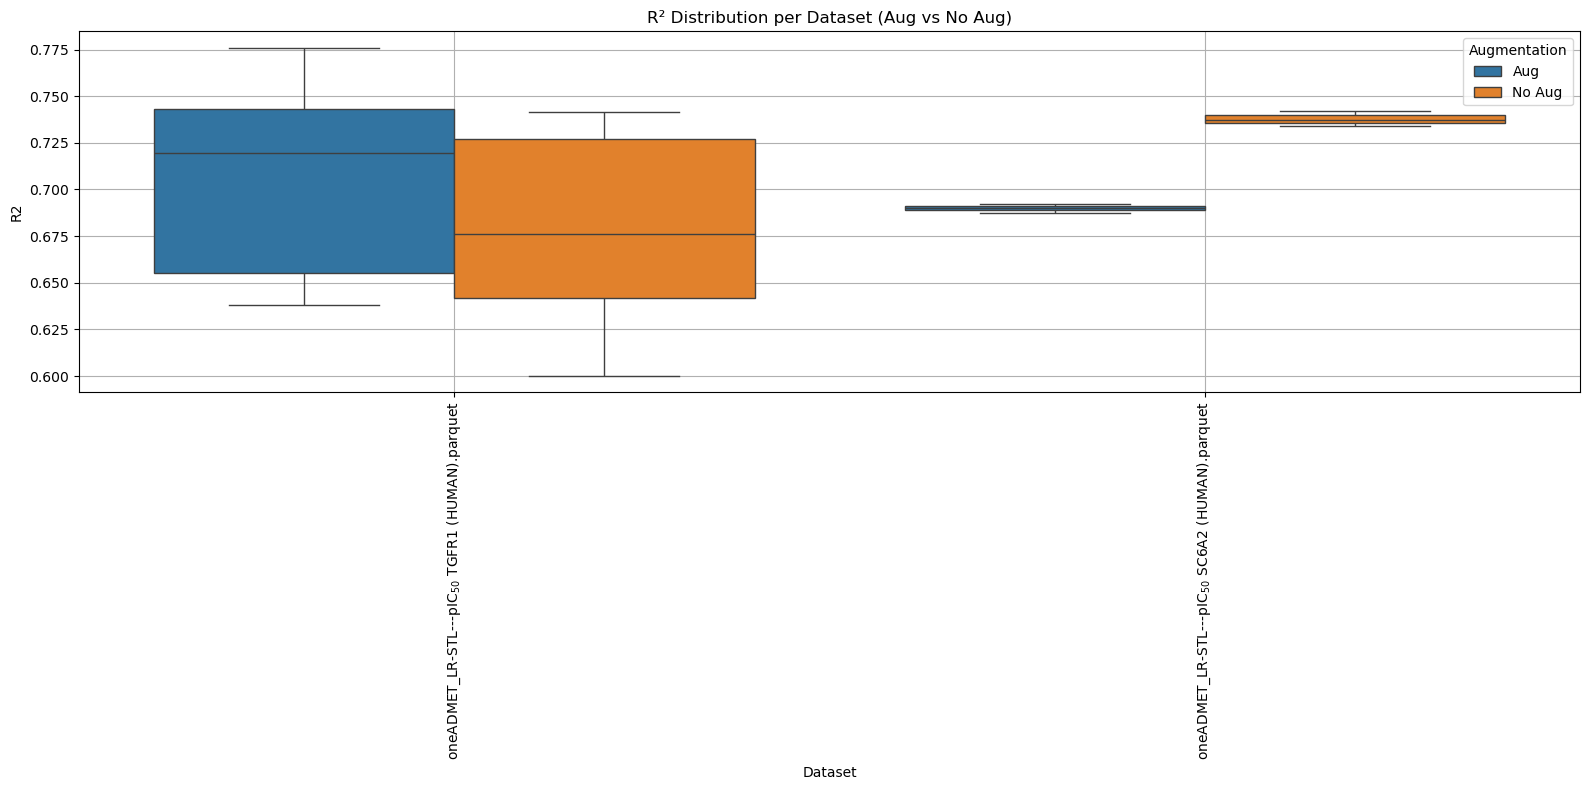

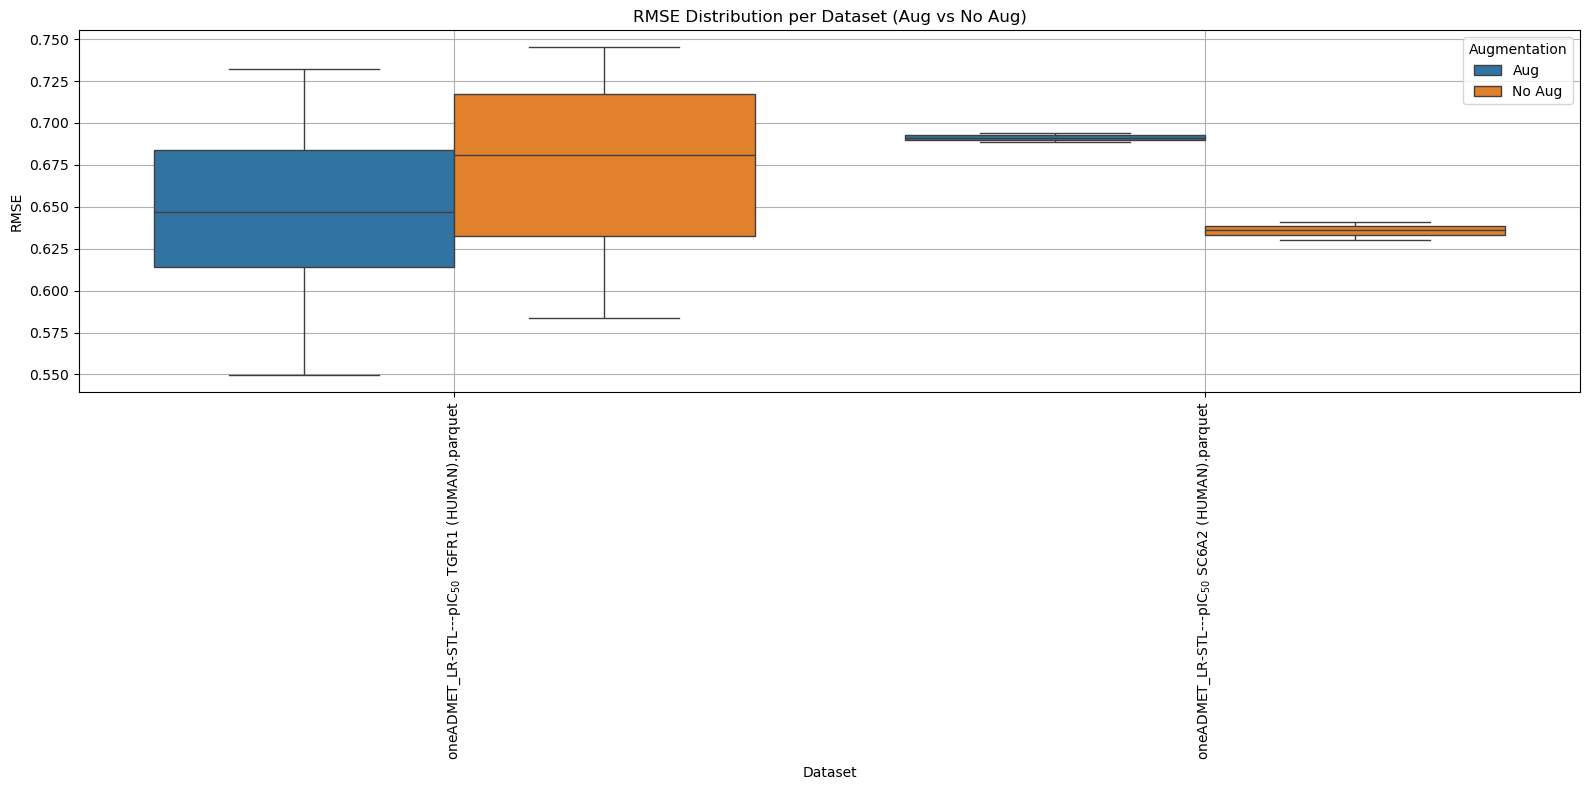

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def collect_perf_stats_all(base_dir_aug, base_dir_noaug, folds, reps=[1, 2, 3]):
    records = []

    # Collect all dataset filenames from one fold
    fold_dir = os.path.join(base_dir_aug, 'ABCDEFGHI', "STL", "RF_ECFP")
    all_files = [f for f in os.listdir(fold_dir) if f.endswith(".parquet")]

    print(fold_dir)

    for dataset_name in all_files:
        print(dataset_name)
        for aug_type, base_dir in zip(["Aug", "No Aug"], [base_dir_aug, base_dir_noaug]):
            for d in folds:
                file_path = os.path.join(base_dir, d, "STL", "RF_ECFP", dataset_name)
                if not os.path.exists(file_path):
                    continue
                try:
                    df = pd.read_parquet(file_path)
                    for k in reps:
                        y_true = df["Y"].tolist()
                        y_pred = df[f"pY_rep{k}"].tolist()
                        rmse = mean_squared_error(y_true, y_pred, squared=False)
                        r2 = r2_score(y_true, y_pred)
                        records.append({
                            "Dataset": dataset_name,
                            "Fold": d,
                            "Augmentation": aug_type,
                            "RMSE": rmse,
                            "R2": r2,
                            "Rep": k
                        })
                except:
                    continue

    df_perf = pd.DataFrame(records)

    # R² plot
    plt.figure(figsize=(16, 8))
    sns.boxplot(x="Dataset", y="R2", hue="Augmentation", data=df_perf)
    plt.title("R² Distribution per Dataset (Aug vs No Aug)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # RMSE plot
    plt.figure(figsize=(16, 8))
    sns.boxplot(x="Dataset", y="RMSE", hue="Augmentation", data=df_perf)
    plt.title("RMSE Distribution per Dataset (Aug vs No Aug)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_perf

# Example usage
df_stats_all = collect_perf_stats_all(
    base_dir_aug="../data/prediction/aug",
    base_dir_noaug="../data/prediction/noaug",
    folds=["BCDEFGHIJ", "ACDEFGHIJ", "ABDEFGHIJ", "ABCEFGHIJ","ABCDFGHIJ", "ABCDEGHIJ", "ABCDEFHIJ", "ABCDEFGIJ", "ABCDEFGHJ","ABCDEFGHI"]
)